In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from tensorflow.keras.layers import Input, Embedding, Add, Dot, Flatten
from tensorflow.keras import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Activation
from tensorflow.keras import backend as K

%matplotlib inline

In [2]:
# define base path for file reading
base_path = "/content/drive/MyDrive/notebooks-share/"
# read main dataframe
df = pd.read_pickle(base_path + "finaldf.pkl")
df.drop('index', axis=1, inplace=True)
# display top rows
df.head()

,user_id,date,rating,business_id,name,latitude,longitude,avg_rest_rating,review_count,attributes,avg_user_rating,fans,user_review_count,useful
0,V34qejxNsCbcgD8C0HVk-Q,2015-12-05 03:18:11,5.0,HQl28KMwrEKHqhFrrDqVNQ,Deagan's Kitchen & Bar,41.485192,-81.800145,4.0,417,"{'BusinessAcceptsCreditCards': 'True', 'Outdoo...",4.02,20,199,232
1,UgMW8bLE0QMJDCkQ1Ax5Mg,2017-01-14 21:56:57,4.0,IS4cv902ykd8wj1TR0N3-A,Raising Cane's Chicken Fingers,36.035068,-115.046353,3.5,159,"{'DriveThru': 'True', 'GoodForMeal': '{'desser...",3.61,12,293,304
2,5vD2kmE25YBrbayKhykNxQ,2013-05-07 07:25:25,5.0,nlxHRv1zXGT0c0K51q3jDg,Firehouse Subs,36.059969,-115.036032,3.0,93,"{'Ambience': '{'romantic': False, 'intimate': ...",3.91,36,251,1242
3,aq_ZxGHiri48TUXJlpRkCQ,2015-11-05 23:11:05,5.0,Pthe4qk5xh4n-ef-9bvMSg,Chon Thai Food,33.339962,-111.859727,4.5,555,"{'RestaurantsPriceRange2': '2', 'RestaurantsTa...",4.61,1,55,36
4,HJECayULRM-6xh2GCCvLiA,2015-10-17 01:38:13,4.0,l-nL4BmhzpZjcavooO48PQ,The Wokker Restaurant,43.648896,-79.604506,3.5,33,"{'Alcohol': 'u'full_bar'', 'BusinessParking': ...",3.55,13,314,367


In [81]:
print("Total Unique Users: {}".format(df.user_id.nunique()))
print("Total Unique Restaurants: {}".format(df.business_id.nunique()))

Total Unique Users: 545384
Total Unique Restaurants: 43743


In [82]:
# create a copy of dataframe
df_clean = df.copy()
# filter out rows with less than 50 review_counts and user_review_counts
df_clean_new = df_clean[(df_clean.user_review_count >= 50) & (df_clean.review_count >= 50)].copy()
# drop unnecessary columns
df_work = df_clean_new.drop(['user_review_count','review_count', 'useful', 'fans', 'avg_rest_rating', 'avg_user_rating', 'latitude', 'longitude', 'attributes'], axis=1)
df_work.head()

,user_id,date,rating,business_id,name
0,V34qejxNsCbcgD8C0HVk-Q,2015-12-05 03:18:11,5.0,HQl28KMwrEKHqhFrrDqVNQ,Deagan's Kitchen & Bar
1,UgMW8bLE0QMJDCkQ1Ax5Mg,2017-01-14 21:56:57,4.0,IS4cv902ykd8wj1TR0N3-A,Raising Cane's Chicken Fingers
2,5vD2kmE25YBrbayKhykNxQ,2013-05-07 07:25:25,5.0,nlxHRv1zXGT0c0K51q3jDg,Firehouse Subs
3,aq_ZxGHiri48TUXJlpRkCQ,2015-11-05 23:11:05,5.0,Pthe4qk5xh4n-ef-9bvMSg,Chon Thai Food
5,2hRe26HSCAWbFRn5WChK-Q,2015-02-02 06:28:00,1.0,d4qwVw4PcN-_2mK2o1Ro1g,Pink Taco


In [83]:
# load business.json file
businessdf = pd.read_json(base_path+'yelp_academic_dataset_business.json', lines = True)
businessdf['city_state'] = businessdf['city'] + ', ' + businessdf['state']

# read user pickle file for some data like username
userdf = pd.read_pickle(base_path+"yelp_academic_dataset_user.pkl")
userdf = userdf.drop_duplicates(subset='user_id')
userdf_new = userdf[['user_id', 'friends', 'name']].copy()

userdf_new.rename(columns={'name': 'username'}, inplace=True)
# save file for faster loading if colab crashes
userdf_new.to_csv('/content/userdf_new.csv')
userdf_new.head()

,user_id,friends,username
0,ntlvfPzc8eglqvk92iDIAw,"oeMvJh94PiGQnx_6GlndPQ, wm1z1PaJKvHgSDRKfwhfDg...",Rafael
1,FOBRPlBHa3WPHFB5qYDlVg,"ly7EnE8leJmyqyePVYFlug, pRlR63iDytsnnniPb3AOug...",Michelle
2,zZUnPeh2hEp0WydbAZEOOg,"Uwlk0txjQBPw_JhHsQnyeg, Ybxr1tSCkv3lYA0I1qmnPQ...",Martin
3,QaELAmRcDc5TfJEylaaP8g,"iog3Nyg1i4jeumiTVG_BSA, M92xWY2Vr9w0xoH8bPplfQ...",John
4,xvu8G900tezTzbbfqmTKvA,"3W3ZMSthojCUirKEqAwGNw, eTIbuu23j9tOgmIa9POyLQ...",Anne


In [84]:
#columns needed
columns = ['business_id', 'city_state', 'address', 'name', 'categories']
# add some columns that will be needed later (post-prediction)
df_work = pd.merge(df_work.copy(), businessdf[columns].drop('name', axis=1), how='left', on='business_id')
df_work = pd.merge(df_work.copy(), userdf_new, how='left', on='user_id')
df_work.head()

,user_id,date,rating,business_id,name,city_state,address,categories,friends,username
0,V34qejxNsCbcgD8C0HVk-Q,2015-12-05 03:18:11,5.0,HQl28KMwrEKHqhFrrDqVNQ,Deagan's Kitchen & Bar,"Lakewood, OH",14810 Detroit Ave,"Restaurants, Gastropubs, Nightlife, American (...","ZlOgxIThXJYkHPLj2fiYAw, XZg_60BabYR1t2aGqN10PQ...",Danielle
1,UgMW8bLE0QMJDCkQ1Ax5Mg,2017-01-14 21:56:57,4.0,IS4cv902ykd8wj1TR0N3-A,Raising Cane's Chicken Fingers,"Henderson, NV",110 N Stephanie St,"Fast Food, Restaurants, Sandwiches, Chicken Wings","MC0e6zrMjetYx9zIjrV8cw, qfXZ6IYtWJNX5wc1gy_mhQ...",Micah
2,5vD2kmE25YBrbayKhykNxQ,2013-05-07 07:25:25,5.0,nlxHRv1zXGT0c0K51q3jDg,Firehouse Subs,"Henderson, NV","510 Marks St, Unit B-1, Ste 110","Restaurants, Delis, Sandwiches, Fast Food","vdR9dCBu7snPWHnWVV8XxA, ZhLo7Npbba3rA9A3mtkNow...",Gary
3,aq_ZxGHiri48TUXJlpRkCQ,2015-11-05 23:11:05,5.0,Pthe4qk5xh4n-ef-9bvMSg,Chon Thai Food,"Chandler, AZ","2330 N Alma School Rd, Ste 116","Restaurants, Thai","bOZsEwbBpRmIH9IXjWMw6g, uJO3fQ51I1Db-WvShGqlXw...",Jagan
4,2hRe26HSCAWbFRn5WChK-Q,2015-02-02 06:28:00,1.0,d4qwVw4PcN-_2mK2o1Ro1g,Pink Taco,"Las Vegas, NV",4455 Paradise Rd,"Mexican, Restaurants","-uybOghOlhc_UHEZvkyShQ, EWEEHDderP1sswVNhEj4qw...",Mike


In [85]:
#need to create idx for user_id and business_id
users = df_work.user_id.unique()
restaurants = df_work.business_id.unique()

In [86]:
# map ids to indices
userid2idx = {o:i for i,o in enumerate(users)}
restaurantid2idx = {o:i for i,o in enumerate(restaurants)}

df_work['restaurantidx'] = df_work.business_id.apply(lambda x: restaurantid2idx[x])
df_work['useridx'] = df_work.user_id.apply(lambda x: userid2idx[x])

In [87]:
# get all unique user ids
nusers = df_work.useridx.nunique()
# get all unique restaurant ids
nrestaurants = df_work.restaurantidx.nunique()

In [88]:
#creating train, val and test data based on when the rating was given; 
#the most recent ratings are heldout. The second most are in validation and the rest are in train.

In [89]:
ratings_user_date = df_work.loc[:, ['useridx', 'date']]
index_holdout = ratings_user_date.groupby(['useridx'], sort=False)['date'].transform(max) == ratings_user_date['date']
#groupby user and transfrom the data with indices true if review is most recent and false if not
ratings_holdout_ = df_work[index_holdout] #all the ones that are true
ratings_traincv_ = df_work[~index_holdout] # all the false

In [90]:
#now we split the traincv into train and cv with cv having the second most recent and train, the rest
ratings_user_date = ratings_traincv_.loc[:, ['useridx', 'date']] 
index_holdout = ratings_user_date.groupby(['useridx'], sort=False)['date'].transform(max) == ratings_user_date['date']
ratings_cv_ = ratings_traincv_[index_holdout]
ratings_train_ = ratings_traincv_[~index_holdout]

In [91]:
# remove users who aren't real.
cv_users_del = set(ratings_cv_.useridx) - set(ratings_train_.useridx) #set is an unordered collection of items. All unique
ratings_cv_ = ratings_cv_[~ratings_cv_.useridx.isin(cv_users_del)]

holdout_users_del = set(ratings_holdout_.useridx) - set(ratings_train_.useridx)
ratings_holdout_ = ratings_holdout_[~ratings_holdout_.user_id.isin(holdout_users_del)]

In [92]:
print('There are {0} rows, {1} columns in training set'.format(ratings_train_.shape[0], ratings_train_.shape[1]))
print('There are {0} rows, {1} columns in validation set'.format(ratings_cv_.shape[0], ratings_cv_.shape[1]))
print('There are {0} rows, {1} columns in holdout/test set'.format(ratings_holdout_.shape[0], ratings_holdout_.shape[1]))

There are 1183521 rows, 12 columns in training set
There are 79978 rows, 12 columns in validation set
There are 149541 rows, 12 columns in holdout/test set


In [93]:
# input variables that determine the size of our latent space and the regualrization
L = 100 #latent space
REG = 5e-5 #regualrizattion

In [94]:
def create_bias(name, inp, n_in, reg):
    x = Embedding(n_in, 1, input_length=1, name=name)(inp)
    return Flatten(name=name+'_flat')(x)

def embedding_input(name, n_in, n_out, reg):
    inp = Input(shape=(1,), dtype='int64', name=name)
    return inp, Embedding(n_in, n_out, input_length=1, name=name.split('_')[0]+'_factor', embeddings_regularizer=l2(reg))(inp)

def sigmoid_maker(low, high):
    def custom_sigmoid(x):
        return K.sigmoid(x)*(high - low) + low
    return custom_sigmoid

In [95]:
# creating the embedding input, latent space and the bias
user_input, uLmat = embedding_input('user_input', nusers, L, REG)
restaurant_input, mLmat = embedding_input('restaurant_input', nrestaurants, L, REG)

user_bias = create_bias('user_bias', user_input, nusers, REG)
restaurant_bias = create_bias('restaurant_bias',restaurant_input, nrestaurants, REG)

In [96]:
user_input.shape, restaurant_input.shape, user_bias.shape, restaurant_bias.shape, uLmat.shape, mLmat.shape

(TensorShape([None, 1]),
 TensorShape([None, 1]),
 TensorShape([None, 1]),
 TensorShape([None, 1]),
 TensorShape([None, 1, 100]),
 TensorShape([None, 1, 100]))

In [97]:
# residual matrix is the dot product of our identity matrices
residual = Dot(axes=2, name="residual")([uLmat, mLmat])
# flatten it
residflat = Flatten(name="residual_flat")(residual)
residflat.shape

TensorShape([None, 1])

In [98]:
# our model architecture
regression = Add(name="regression")([user_bias, restaurant_bias, residflat]) #here is our utility matrix!!
cs = sigmoid_maker(0, 5.5)
output = Activation(cs, name="Sigmoid_Range")(regression)

In [99]:
# create model
model = Model([user_input, restaurant_input], output)
# compile model
model.compile(Adam(0.001), loss='mse')

In [100]:
# display model summary
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
restaurant_input (InputLayer)   [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_factor (Embedding)         (None, 1, 100)       14953500    user_input[0][0]                 
__________________________________________________________________________________________________
restaurant_factor (Embedding)   (None, 1, 100)       1629500     restaurant_input[0][0]           
____________________________________________________________________________________________

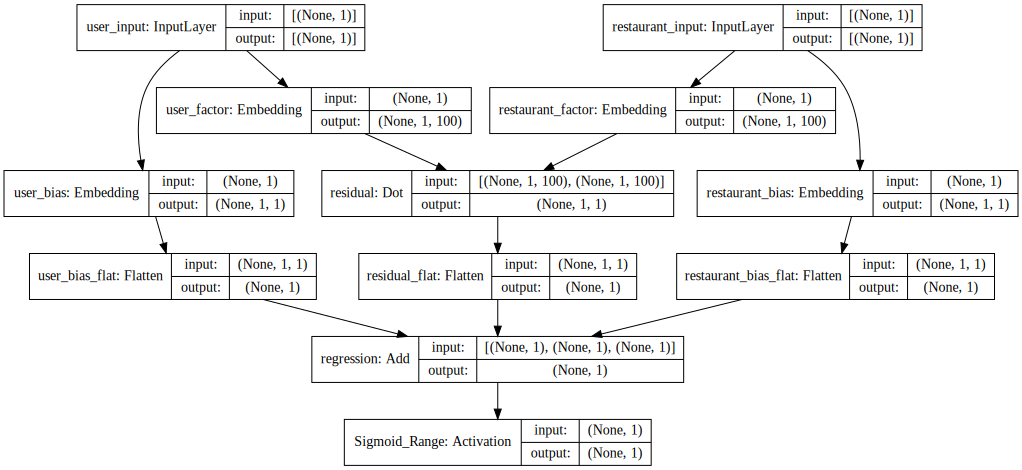

In [116]:
from tensorflow.keras.utils import model_to_dot
from IPython.display import SVG
SVG(model_to_dot(model,  show_shapes=True, show_layer_names=True, dpi=72, rankdir='TB').create_svg())

In [102]:
# fitting the model
# model.optimizer.lr=0.001
model.fit([ratings_train_.useridx, ratings_train_.restaurantidx], ratings_train_.rating, batch_size=64, epochs=1, 
          validation_data=([ratings_cv_.useridx, ratings_cv_.restaurantidx], ratings_cv_.rating))

In [103]:
# load saved weights for a model
model.load_weights(base_path+'sgd_weights.h5')

In [114]:
# Evalute on a test set
mse = model.evaluate([ratings_holdout_.useridx, ratings_holdout_.restaurantidx], ratings_holdout_.rating)
print("Test set error: {:.4f}".format(mse))

4674/4674 [==============================] - 170s 36ms/step - loss: 2.9266
Test set error: 2.9112


In [104]:
def predict_ratings(useridx, restaurantidx):
  predictions = model.predict([useridx, restaurantidx])
  return predictions

In [105]:
def recommend_restaurants(userid):
  # create a new df with ids and indices of users and restaurants
  ids_df = df_work[['user_id', 'restaurantidx', 'business_id', 'city_state']].copy()
  ids_df['visited'] = ids_df.user_id.apply(lambda x: True if x == userid else False)
  
  # filter out restaurants visited by a user
  user_visited = ids_df[ids_df.visited == True]
  ids_df = ids_df[ids_df['visited'] == False]
  # save most visited cities by user
  user_city_state = list(user_visited.city_state.value_counts().index)

  # create new df for prediction
  new_df = pd.DataFrame()
  new_df['business_id'] = ids_df.business_id.unique()
  new_df['restaurantidx'] = new_df.business_id.apply(lambda x: restaurantid2idx[x])
  new_df['useridx'] = userid2idx[userid]
  new_df['predicted_ratings'] = predict_ratings(new_df.useridx, new_df.restaurantidx)
  # define columns to merge
  columns = ['business_id', 'name', 'city_state', 'address', 'categories']
  new_df = pd.merge(new_df.copy(), df_work[columns], how='left', on='business_id')
  new_df.sort_values(by='predicted_ratings', ascending=False, inplace=True)
  # return new_df.drop_duplicates()
  final_df = pd.DataFrame()
  # re-order rows based on most frequent visited cities
  for city_state in user_city_state:
    final_df = pd.concat([final_df, new_df[new_df.city_state == city_state]])

  return final_df.drop_duplicates().drop(columns=['restaurantidx', 'useridx']).reset_index(drop=True)


In [106]:
# Filtering top recommendations based on user's friends average ratings
def recommend_based_on_friends(userid):
  # if a user doesn't have any friends in the list
  if userdf[userdf.user_id == userid]['friends'].values[0] == 'None':
    return "This user doesn't have any friend in the list"
  # get user friends user ids in a list
  friends = userdf[userdf.user_id == userid]['friends'].values[0].replace(' ', '').split(',')

  # get the new df with user ids, business_ids and ratings
  friendsdf = df_work[df_work.user_id.isin(friends)][['user_id', 'business_id', 'rating']].copy()

  # calculate average ratings by friendsd on all business_ids (restaurants rated by friends)
  avg_frns_ratingdf = friendsdf.groupby('business_id')[['rating']].mean()

  # filter out average ratings less than 4
  ratings_4 = avg_frns_ratingdf[avg_frns_ratingdf.rating >= 4.0].copy()

  # change column name to prevent clash later while merging
  ratings_4.rename(columns={'rating': 'avg_friends_rating'}, inplace=True)
  ratings_4.sort_values(by='avg_friends_rating', ascending=False, inplace=True)
  ratings_4.reset_index(inplace=True)
  # merge recommenddf and ratings_4 to make better recommendations
  friends_recommend_df = pd.merge(recommend_df, ratings_4, how='left', on='business_id')
  # sort using friends average ratings and user predicted ratings and return
  friends_recommend_df.sort_values(by=['avg_friends_rating', 'predicted_ratings'], ascending=False, inplace=True)
  return friends_recommend_df.reset_index(drop=True)


In [107]:
# try on one user_id to verify if it's working or not
user1 = users[18]
recommend_df = recommend_restaurants(user1)
liked_by_friends = recommend_based_on_friends(user1)
top20recommendations = recommend_df.head(20)

In [108]:
# Users past ratings
df_work[df_work.user_id == user1][['username', 'name', 'rating', 'city_state', 'categories']]

,username,name,rating,city_state,categories
18,Kelly,Crush,4.0,"Las Vegas, NV","Nightlife, Lounges, Restaurants, Tapas Bars, B..."
20102,Kelly,Monkey Pants Bar & Grill,4.0,"Tempe, AZ","Nightlife, Burgers, Bars, Dive Bars, Restauran..."
22614,Kelly,Desert Roots Kitchen,3.0,"Tempe, AZ","Gluten-Free, Vegetarian, Vegan, Restaurants"
44849,Kelly,Four Peaks Grill & Tap,4.0,"Scottsdale, AZ","Local Flavor, Food, Breakfast & Brunch, Restau..."
55733,Kelly,Windsor,3.0,"Phoenix, AZ","Bars, Breakfast & Brunch, Pubs, American (New)..."
...,...,...,...,...,...
1343478,Kelly,Yard House,4.0,"Scottsdale, AZ","Restaurants, American (New), Nightlife, Asian ..."
1351244,Kelly,Rusty Spur Saloon,4.0,"Scottsdale, AZ","Bars, American (New), Restaurants, Arts & Ente..."
1369821,Kelly,Caffe Boa,3.0,"Tempe, AZ","Restaurants, Italian, American (New), Breakfas..."
1370155,Kelly,Cornish Pasty,5.0,"Tempe, AZ","Restaurants, Bars, Pubs, British, Nightlife, E..."


In [70]:
# Top 20 recommendations based on mostly visited cities using Adam Optimizer
top20recommendations[['name', 'predicted_ratings', 'city_state', 'address', 'categories']]

,name,predicted_ratings,city_state,address,categories
0,Brew Tea Bar,4.879714,"Las Vegas, NV","7380 S Rainbow Blvd, Ste 101","Restaurants, Food, Cafes, Tea Rooms, Bubble Te..."
1,Bajamar Seafood & Tacos,4.791226,"Las Vegas, NV",1615 S Las Vegas Blvd,"Fast Food, Dive Bars, Bars, Tacos, Seafood, Ni..."
2,Kabuto,4.779916,"Las Vegas, NV","5040 Spring Mountain Rd, Ste 4","Food, Japanese, Sushi Bars, Restaurants"
3,Fountains of Bellagio,4.769692,"Las Vegas, NV",3600 S Las Vegas Blvd,"Street Art, Landmarks & Historical Buildings, ..."
4,Soho Japanese Restaurant,4.703552,"Las Vegas, NV","7377 S Jones Blvd, Ste 116t","Sushi Bars, Asian Fusion, Japanese, Restaurants"
5,Karved,4.683604,"Las Vegas, NV",3957 S Maryland Pkwy,"Restaurants, Sandwiches, Fast Food, Salad, Ame..."
6,Meráki Greek Grill,4.672693,"Las Vegas, NV","4950 S Rainbow Blvd, Ste 160","Mediterranean, Restaurants, Greek"
7,Zenaida's Cafe,4.651720,"Las Vegas, NV","3430 E Tropicana Ave, Ste 32","Cafes, Breakfast & Brunch, Restaurants"
8,Baguette Cafe,4.648234,"Las Vegas, NV","8359 W Sunset Rd, Ste 100","Delis, Vegan, Restaurants, French, Food, Coffe..."
9,The Goodwich Downtown,4.646438,"Las Vegas, NV","900 S Las Vegas Blvd, Ste 120","Breakfast & Brunch, Desserts, Sandwiches, Rest..."


In [109]:
# Top 20 recommendations based on mostly visited cities with SGD
top20recommendations[['name', 'predicted_ratings', 'city_state', 'address', 'categories']]

,name,predicted_ratings,city_state,address,categories
0,Citizen Public House,3.441685,"Scottsdale, AZ","7111 E 5th Ave, Ste E","Bars, Local Flavor, Gastropubs, Cocktail Bars,..."
1,Olive & Ivy,3.419085,"Scottsdale, AZ","7135 E Camelback Rd, Ste 195","American (Traditional), Venues & Event Spaces,..."
2,The Mission Old Town,3.384028,"Scottsdale, AZ",3815 N Brown Ave,"Restaurants, Latin American, Nightlife, Mexica..."
3,Rehab Burger Therapy,3.377571,"Scottsdale, AZ",7210 E 2nd St,"Nightlife, Sandwiches, Restaurants, American (..."
4,"DeFalco's Italian Eatery, Grocery & Deli",3.320098,"Scottsdale, AZ","2334 N Scottsdale Rd, Ste A133","Delis, Sandwiches, Food, Restaurants, Grocery,..."
5,Butters Pancakes & Café,3.270645,"Scottsdale, AZ","8300 N Hayden Rd, Ste F104","Restaurants, Waffles, Wraps, Food, Coffee & Te..."
6,Roaring Fork,3.247202,"Scottsdale, AZ","4800 N Scottsdale Rd, Ste 1700","Nightlife, Food, Desserts, Bars, Steakhouses, ..."
7,Culinary Dropout,3.243656,"Scottsdale, AZ","7135 E Camelback Rd, Ste 125","American (New), Bars, Food, Restaurants, Night..."
8,Fogo de Chão Brazilian Steakhouse,3.222026,"Scottsdale, AZ",6300 N Scottsdale Rd,"Restaurants, Brazilian, Food, Seafood, Steakho..."
9,True Food Kitchen,3.201366,"Scottsdale, AZ","15191 N Scottsdale Rd, Ste 101","Vegetarian, Pizza, Vegan, Salad, Food, America..."


In [110]:
# Here are some of the resturants your friends liked the most
def display_df(df):
  return df
display_df(liked_by_friends)
# liked_by_friends[['name', 'predicted_ratings', 'city_state', 'address', 'categories', 'avg_friends_rating']].head(10)


,business_id,predicted_ratings,name,city_state,address,categories,avg_friends_rating
0,DkYS3arLOhA8si5uUEmHOw,4.011049,Earl of Sandwich,"Las Vegas, NV",3667 Las Vegas Blvd S,"Restaurants, Food Delivery Services, Salad, Wr...",5.0
1,Wxxvi3LZbHNIDwJ-ZimtnA,3.762977,The Venetian Las Vegas,"Las Vegas, NV",3355 South Las Vegas Boulevard,"Resorts, Car Wash, Shopping Centers, Shopping,...",5.0
2,I6EDDi4-Eq_XlFghcDCUhw,3.633151,Joes Seafood Prime Steak & Stone Crab,"Las Vegas, NV",3500 Las Vegas Blvd S,"Steakhouses, Seafood, Nightlife, Restaurants, ...",5.0
3,3kdSl5mo9dWC4clrQjEDGg,3.526371,Egg & I,"Las Vegas, NV","4533 W Sahara Ave, Ste 5","American (Traditional), Breakfast & Brunch, Pi...",5.0
4,OETh78qcgDltvHULowwhJg,3.521330,Gordon Ramsay Steak,"Las Vegas, NV",3655 Las Vegas Blvd S,"Restaurants, Steakhouses, American (New), Soup...",5.0
...,...,...,...,...,...,...,...
5441,LBwFjTUlDeikknOoQTXxhg,2.680127,McDonald's,"Las Vegas, NV",2340 S Rainbow,"Restaurants, Burgers, Fast Food, Coffee & Tea,...",NaN
5442,2IvrdAb6zdxr3ZqplqJHbg,2.673055,Jose Cuervo Tequileria,"Las Vegas, NV",5757 Wayne Newton Blvd,"Mexican, Restaurants",NaN
5443,oDcTa97TuRsNVg8urdw6qA,2.668098,Papa John's Pizza,"Las Vegas, NV","4790 S Fort Apache Rd, Ste A","Pizza, Restaurants",NaN
5444,SIVi2UQp1UT0lMIoqHP0QA,2.665081,Rainforest Cafe,"Tempe, AZ",5000 S Arizona Mills Cir,"Party & Event Planning, American (New), Restau...",NaN


In [111]:
# recommend based on user's current location, (location: city_state)
# this wont work if the user in in the location where he/she has never been to any restaurants or her/his friends never visited
def recommend_based_on_location(userid, location):
  all_city_state = df_work.city_state.unique()
  if location not in all_city_state:
    print('Invalid Location')
    return None
  recommenddf = recommend_restaurants(userid)
  liked_by_friends = recommend_based_on_friends(userid)
  recommenddf = recommenddf[recommenddf.city_state == location]
  liked_by_friends = liked_by_friends[liked_by_friends.city_state == location]

  return recommenddf.head(20), liked_by_friends.head(10)

top20recommendations, liked_by_friends = recommend_based_on_location(users[18], 'Phoenix, AZ')

In [112]:
# Top 20 recommendations based on user's behaviour
top20recommendations

,business_id,predicted_ratings,name,city_state,address,categories
690,VyVIneSU7XAWgMBllI6LnQ,3.563057,Bobby Q,"Phoenix, AZ",8501 N 27th Ave,"Barbeque, Caterers, Event Planning & Services,..."
691,Xg5qEQiB-7L6kGJ5F4K3bQ,3.549150,Little Miss BBQ,"Phoenix, AZ",4301 E University Dr,"Barbeque, Restaurants"
692,OgJ0KxwJcJ9R5bUK0ixCbg,3.488890,Lux Central,"Phoenix, AZ",4400 N Central Ave,"Nightlife, American (New), Bakeries, Breakfast..."
693,9a3DrZvpYxVs3k_qwlCNSw,3.451964,Cibo,"Phoenix, AZ",603 N 5th Ave,"Restaurants, Sandwiches, Italian, Pizza"
694,pSQFynH1VxkfSmehRXlZWw,3.449799,Pizzeria Bianco,"Phoenix, AZ",623 E Adams St,"Sandwiches, Tapas/Small Plates, Restaurants, S..."
695,k1QpHAkzKTrFYfk6u--VgQ,3.395179,The Parlor,"Phoenix, AZ",1916 E Camelback Rd,"Salad, Sandwiches, Pizza, Restaurants, Italian"
696,frCxZS7lPhEnQRJ3UY6m7A,3.387794,La Santisima Gourmet Taco Shop,"Phoenix, AZ",1919 N 16th St,"Cafes, New Mexican Cuisine, Nightlife, Vegetar..."
697,u-SJ5QUwrNquL9VnXwl8cg,3.371275,Postino Arcadia,"Phoenix, AZ",3939 E Campbell Ave,"Restaurants, Nightlife, Wine Bars, Bars, Itali..."
698,FogTa-wmjhVnJCoTiaxvZA,3.361513,Postino Central,"Phoenix, AZ",5144 N Central Ave,"Restaurants, Breakfast & Brunch, Nightlife, Wi..."
699,utIA0LyQmwP-9DRyxUe6qQ,3.325563,"Snooze, An A.M. Eatery","Phoenix, AZ","2045 E Camelback Rd, Ste A17","Breakfast & Brunch, Coffee & Tea, Sandwiches, ..."


In [113]:
# recommendations based on friends average ratings
liked_by_friends

,business_id,predicted_ratings,name,city_state,address,categories,avg_friends_rating
16,L2p0vO3fsS2LC6hhQo3CzA,3.295663,Matt's Big Breakfast,"Phoenix, AZ",825 N 1st St,"Restaurants, Salad, Breakfast & Brunch, Americ...",5.0
20,E4JyAzB5_2quptwtemyhYA,3.214114,Original Breakfast House,"Phoenix, AZ",13623 N 32nd St,"Restaurants, Seafood, Breakfast & Brunch, Cafe...",5.0
28,EDcZRvERC22Cvw1yi4-VKg,3.064395,The Sicilian Butcher,"Phoenix, AZ","15530 N Tatum Blvd, Ste 160","Sandwiches, Breakfast & Brunch, Restaurants, I...",5.0
29,kBJfBVaXJtPEKLTov1hJdQ,3.058887,Reathrey Sekong,"Phoenix, AZ",1312 E Indian School Rd,"Barbeque, Cambodian, Noodles, Asian Fusion, Re...",5.0
35,WXR0ND0KqbArMZDvFMA-bw,3.029362,Hopdoddy Burger Bar,"Phoenix, AZ","2033 E Camelback Rd, Ste A13","Juice Bars & Smoothies, Food, Nightlife, Resta...",5.0
36,fSBhe0A6Dfa8JCYccfpMog,3.019138,The Bagel Man,"Phoenix, AZ",5035 E Elliot Rd,"Bagels, Restaurants, Delis, Food, Breakfast & ...",5.0
43,0Buxoc0cRqjpvkezo3bqog,2.968369,Nobuo At Teeter House,"Phoenix, AZ",622 E Adams St,"Restaurants, Caterers, Japanese, Tea Rooms, Fo...",5.0
44,xS5HGqgk0KY2jFWU-l_nrA,2.957148,The Covenant,"Phoenix, AZ","4740 E Shea Blvd, Ste 104","Bars, Food, Coffee & Tea, Nightlife, American ...",5.0
45,DaVTuhzi6EgWStb2eAjNjA,2.956104,Presidio Cocina Mexicana,"Phoenix, AZ",519 W Thomas Rd,"Restaurants, Food, Cafes, Cocktail Bars, Mexic...",5.0
46,tcgmfbWugkHI3FRrjlH6lQ,2.955843,Feeney's Restaurant and Bar,"Phoenix, AZ",6314 N 12th St,"American (Traditional), Nightlife, Restaurants...",5.0


### We are using 4 functions to recommend restaurants to a user:

1. **predict_ratings**: takes a userid as an input and predicts ratings for all the restaurant which are not rated by the that user.

2. **recommend_restaurants**: takes userid as an input and recommeends restaurants based on predicted ratings.

3. **recommend_based_on_friends**: this will calculate average rating of all the friends of a user on the restaurants they have rated and recommends user based on that average ratings.

4. **recommend_based_on_location**: this will simply recommend user the restaurants using above functions but also takes a user’s current location into consideration.
(Only recommends those restaurants which are located in users current location)